# Results Analysis: UMAP-like vs Cosine kNN Graphs and Approaches
This notebook compares model results across two graph constructions (`umap_like` and `cos_sim_graph`) and three approach families:
- `csr`: base model and base + Correct-and-Smooth
- `GNN`: GCN and GraphSAGE (PyG)
- `prc`: per-user propagation approach
It reports mean metrics, distributions, and cross-graph comparisons.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

BASE_RESULTS_DIR = 'results'

METRICS = ['accuracy','f1','roc_auc','precision','recall']

pd.set_option('display.max_colwidth', 120)
sns.set_context('talk')

In [ ]:
from typing import Optional, Tuple, List, Dict

APPROACH_PATHS = {
    'csr_base': ('csr', 'correct_smooth_results_base.csv', 'CSR Base'),
    'csr_cs':   ('csr', 'correct_smooth_results_correct_smooth.csv', 'CSR + C&S'),
    'prc':      ('prc', 'prc_user_based_results.csv', 'PRC User-Based'),
    'gnn_gcn':  ('GNN', 'gnn_gcn_results.csv', 'GNN GCN'),
    'gnn_sage': ('GNN', 'gnn_graphsage_results.csv', 'GNN GraphSAGE'),
}

POSSIBLE_GRAPHS = ['umap_like', 'cos_sim_graph']


def find_existing_path(graph: Optional[str], subdir: str, filename: str) -> Optional[str]:
    candidates = []
    if graph:
        candidates.append(os.path.join(BASE_RESULTS_DIR, graph, subdir, filename))
    candidates.append(os.path.join(BASE_RESULTS_DIR, subdir, filename))
    candidates.append(os.path.join(BASE_RESULTS_DIR, filename))
    for p in candidates:
        if os.path.exists(p):
            return p
    return None


def load_results_for(graph: Optional[str], approach_key: str) -> Optional[pd.DataFrame]:
    subdir, filename, approach_label = APPROACH_PATHS[approach_key]
    path = find_existing_path(graph, subdir, filename)
    if path is None:
        return None
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None
    if 'userId' in df.columns:
            df = df.rename(columns={'userId': 'user_id'})
    cols = [c for c in ['user_id'] + METRICS if c in df.columns]
    if cols:
        df = df[cols]
    df['approach_key'] = approach_key
    df['approach'] = approach_label
    df['graph'] = graph if graph is not None else 'unspecified'
    df['source_path'] = path
    return df


def load_all_available() -> pd.DataFrame:
    frames: List[pd.DataFrame] = []
    for g in POSSIBLE_GRAPHS:
        for k in APPROACH_PATHS.keys():
            df = load_results_for(g, k)
            if df is not None:
                frames.append(df)
    if not frames:
        return pd.DataFrame()
    all_df = pd.concat(frames, ignore_index=True)
    return all_df


def summarize_means(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    group_cols = ['graph', 'approach']
    metric_cols = [m for m in METRICS if m in df.columns]
    summary = df.groupby(group_cols)[metric_cols].mean().reset_index()
    return summary


def align_users(df: pd.DataFrame, graph: str) -> Dict[str, pd.DataFrame]:
    out: Dict[str, pd.DataFrame] = {}
    sub = df[df['graph'] == graph]
    if sub.empty:
        return out
    approach_users = {k: set(g['user_id'].dropna().unique()) for k, g in sub.groupby('approach_key') if 'user_id' in g}
    if not approach_users:
        return out
    common_users = set.intersection(*approach_users.values()) if len(approach_users) > 1 else next(iter(approach_users.values()))
    for k, g in sub.groupby('approach_key'):
        aligned = g[g['user_id'].isin(common_users)].copy()
        out[k] = aligned
    return out

In [4]:
# Load available results and show what we found
all_results = load_all_available()

print("Loaded rows:", len(all_results))
print("By graph and approach:")
display(all_results.groupby(['graph','approach'])['user_id'].count().rename('rows').reset_index().sort_values(['graph','approach']))

print("\nSample of detected sources:")
display(all_results[['graph','approach','source_path']].drop_duplicates().sort_values(['graph','approach']).head(20))

Loaded rows: 956050
By graph and approach:


,graph,approach,rows
0,cos_sim_graph,CSR + C&S,161370
1,cos_sim_graph,CSR Base,161370
2,cos_sim_graph,GNN GCN,345
3,cos_sim_graph,GNN GraphSAGE,345
4,cos_sim_graph,PRC User-Based,154595
5,umap_like,CSR + C&S,161370
6,umap_like,CSR Base,161370
7,umap_like,GNN GCN,345
8,umap_like,GNN GraphSAGE,345
9,umap_like,PRC User-Based,154595



Sample of detected sources:


,graph,approach,source_path
639395,cos_sim_graph,CSR + C&S,results/cos_sim_graph/csr/correct_smooth_results_correct_smooth.csv
478025,cos_sim_graph,CSR Base,results/cos_sim_graph/csr/correct_smooth_results_base.csv
955360,cos_sim_graph,GNN GCN,results/cos_sim_graph/GNN/gnn_gcn_results.csv
955705,cos_sim_graph,GNN GraphSAGE,results/cos_sim_graph/GNN/gnn_graphsage_results.csv
800765,cos_sim_graph,PRC User-Based,results/cos_sim_graph/prc/prc_user_based_results.csv
161370,umap_like,CSR + C&S,results/umap_like/csr/correct_smooth_results_correct_smooth.csv
0,umap_like,CSR Base,results/umap_like/csr/correct_smooth_results_base.csv
477335,umap_like,GNN GCN,results/umap_like/GNN/gnn_gcn_results.csv
477680,umap_like,GNN GraphSAGE,results/umap_like/GNN/gnn_graphsage_results.csv
322740,umap_like,PRC User-Based,results/umap_like/prc/prc_user_based_results.csv


In [5]:
# Summary tables: mean metrics by graph and approach
if not all_results.empty:
    mean_summary = summarize_means(all_results)
    display(mean_summary.sort_values(['graph','approach']).reset_index(drop=True))

    # A wide-format table
    metric_cols = [m for m in METRICS if m in all_results.columns]
    wide = mean_summary.pivot(index='approach', columns='graph', values=metric_cols)
    display(wide)

,graph,approach,accuracy,f1,roc_auc,precision,recall
0,cos_sim_graph,CSR + C&S,0.700423,0.657345,0.756094,0.690475,0.695682
1,cos_sim_graph,CSR Base,0.707190,0.692827,0.756477,0.688600,0.749504
2,cos_sim_graph,GNN GCN,0.598064,0.587176,0.597168,0.574490,0.711477
3,cos_sim_graph,GNN GraphSAGE,0.577583,0.556989,0.563802,0.550423,0.636760
4,cos_sim_graph,PRC User-Based,0.556606,0.667845,0.552726,0.556439,0.896008
5,umap_like,CSR + C&S,0.695607,0.653698,0.742436,0.685258,0.690635
6,umap_like,CSR Base,0.706760,0.692148,0.754867,0.685370,0.751366
7,umap_like,GNN GCN,0.574477,0.567686,0.567895,0.554661,0.652973
8,umap_like,GNN GraphSAGE,0.584357,0.566575,0.566600,0.565039,0.645475
9,umap_like,PRC User-Based,0.555863,0.667716,0.555378,0.555694,0.893870


accuracy                      f1                 roc_auc  \
graph          cos_sim_graph umap_like cos_sim_graph umap_like cos_sim_graph   
approach                                                                       
CSR + C&S           0.700423  0.695607      0.657345  0.653698      0.756094   
CSR Base            0.707190  0.706760      0.692827  0.692148      0.756477   
GNN GCN             0.598064  0.574477      0.587176  0.567686      0.597168   
GNN GraphSAGE       0.577583  0.584357      0.556989  0.566575      0.563802   
PRC User-Based      0.556606  0.555863      0.667845  0.667716      0.552726   

                             precision                  recall            
graph          umap_like cos_sim_graph umap_like cos_sim_graph umap_like  
approach                                                                  
CSR + C&S       0.742436      0.690475  0.685258      0.695682  0.690635  
CSR Base        0.754867      0.688600  0.685370      0.749504  0.751366  
GNN GCN         0.567895      0.574490  0.554661      0.711477  0.652973  
GNN GraphSAGE   0.566600      0.550423  0.565039      0.636760  0.645475  
PRC User-Based  0.555378      0.556439  0.555694      0.896008  0.893870


Graph: cos_sim_graph


,metric,approach,mean
1,accuracy,CSR Base,0.709430
0,accuracy,CSR + C&S,0.700716
2,accuracy,GNN GCN,0.596803
3,accuracy,GNN GraphSAGE,0.576845
4,accuracy,PRC User-Based,0.545452
6,f1,CSR Base,0.702154
5,f1,CSR + C&S,0.661576
9,f1,PRC User-Based,0.656083
7,f1,GNN GCN,0.588218
8,f1,GNN GraphSAGE,0.557376


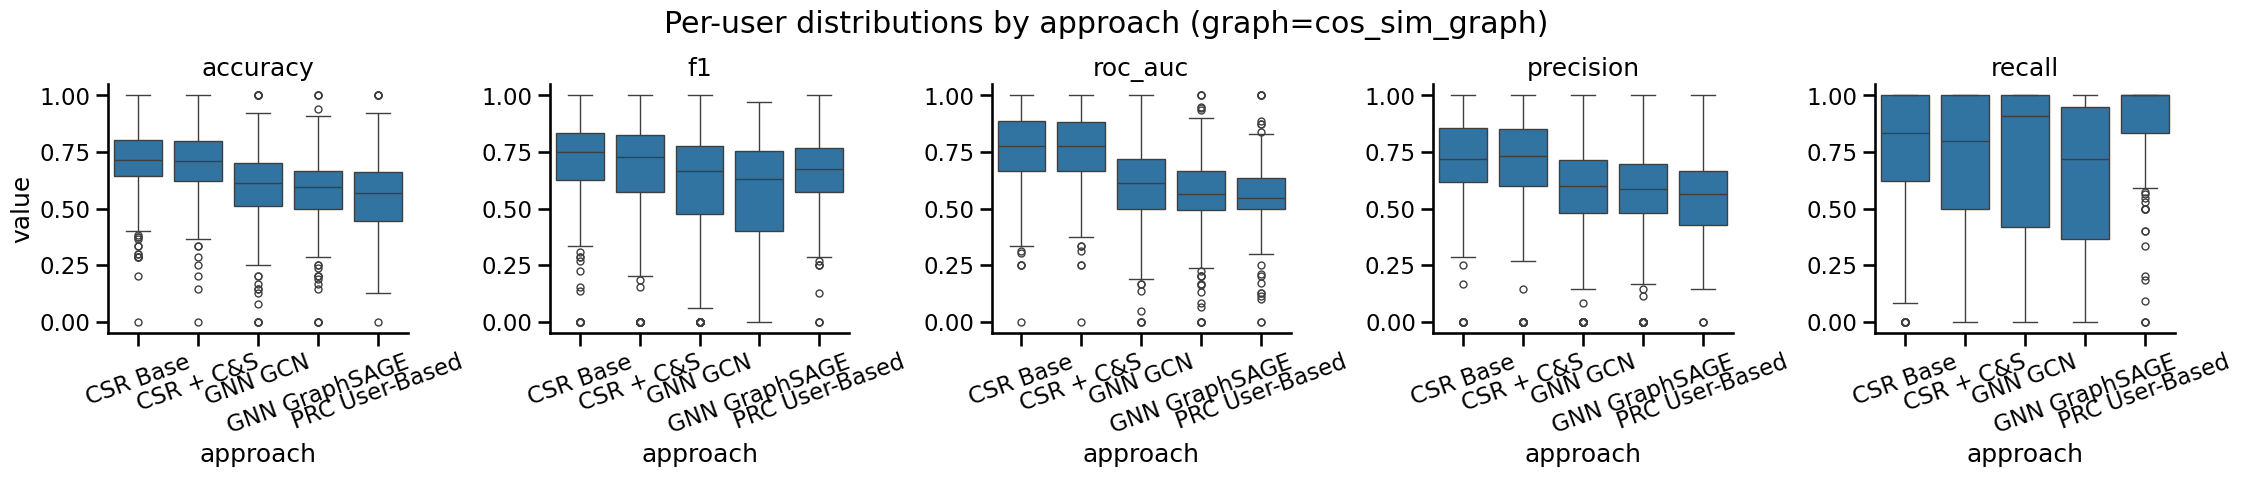


Graph: umap_like


,metric,approach,mean
1,accuracy,CSR Base,0.711116
0,accuracy,CSR + C&S,0.698178
3,accuracy,GNN GraphSAGE,0.583243
2,accuracy,GNN GCN,0.574235
4,accuracy,PRC User-Based,0.545418
6,f1,CSR Base,0.704609
5,f1,CSR + C&S,0.663476
9,f1,PRC User-Based,0.658866
7,f1,GNN GCN,0.567594
8,f1,GNN GraphSAGE,0.566956


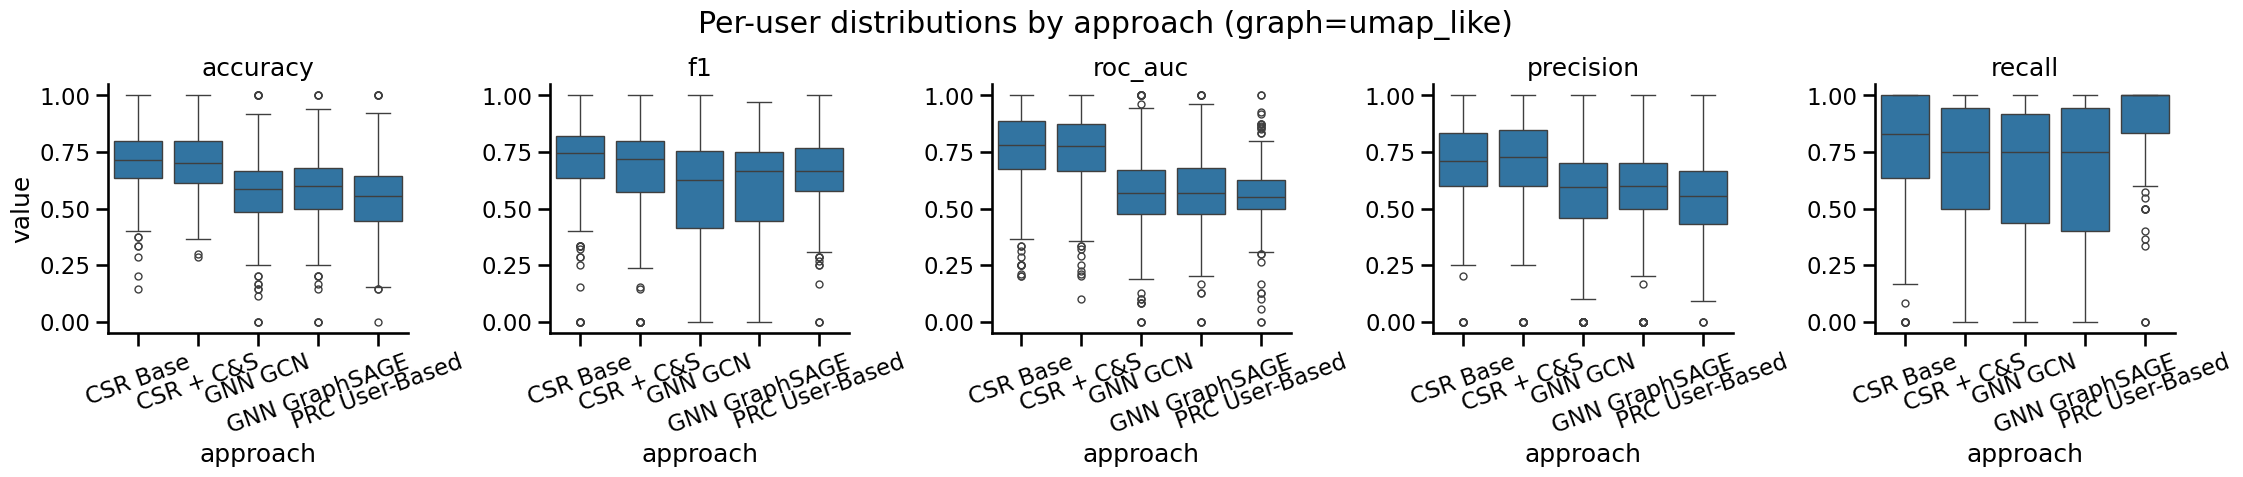

In [6]:
# Within-graph comparisons: aligned user distributions and plots
if not all_results.empty:
    for graph in sorted(all_results['graph'].unique()):
        if graph == 'unspecified':
            continue
        aligned = align_users(all_results, graph)
        if not aligned:
            continue
        print(f"\nGraph: {graph}")
        # Build a long-form frame for seaborn
        frames = []
        for key, dfk in aligned.items():
            label = APPROACH_PATHS[key][2]
            keep_cols = ['user_id'] + [m for m in METRICS if m in dfk.columns]
            dfk2 = dfk[keep_cols].copy()
            dfk2['approach'] = label
            frames.append(dfk2)
        long_df = pd.concat(frames, ignore_index=True)
        long_df = long_df.melt(id_vars=['user_id','approach'], value_vars=[c for c in METRICS if c in long_df.columns], var_name='metric', value_name='value')
        
        display(long_df.groupby(['metric','approach'])['value'].mean().rename('mean').reset_index().sort_values(['metric','mean'], ascending=[True, False]))

        g = sns.catplot(data=long_df, x='approach', y='value', col='metric', kind='box', sharey=False, height=4, aspect=1.1)
        g.set_titles("{col_name}")
        g.set_xticklabels(rotation=20)
        plt.suptitle(f"Per-user distributions by approach (graph={graph})", y=1.05)
        plt.show()


Cross-graph deltas for approach: CSR Base (umap_like - cos_sim_graph)


,metric,mean,median,std,count
0,accuracy,-0.000430,0.0,0.130674,161370
1,f1,-0.000680,0.0,0.181264,158568
2,precision,-0.003230,0.0,0.200984,158568
3,recall,0.001862,0.0,0.249329,158568
4,roc_auc,-0.001610,0.0,0.154793,158568


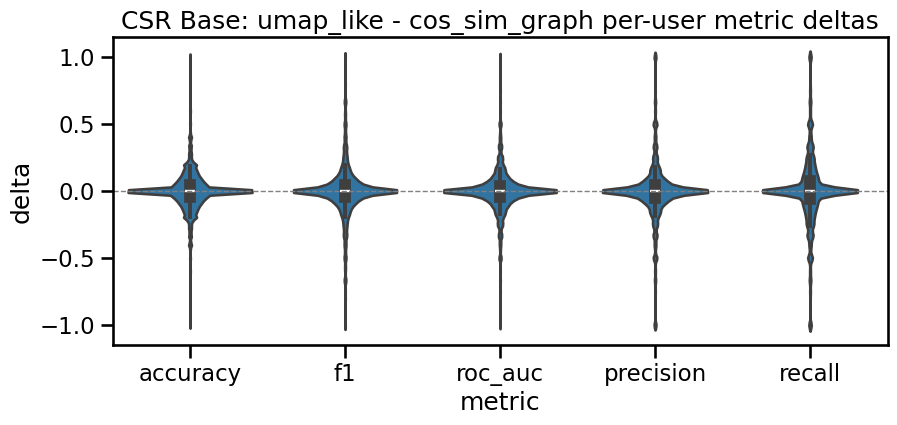


Cross-graph deltas for approach: CSR + C&S (umap_like - cos_sim_graph)


,metric,mean,median,std,count
0,accuracy,-0.004816,0.000000e+00,0.134415,161370
1,f1,-0.003647,0.000000e+00,0.203469,158568
2,precision,-0.005217,0.000000e+00,0.234051,158568
3,recall,-0.005047,0.000000e+00,0.271153,158568
4,roc_auc,-0.013658,-1.110223e-16,0.156686,158568


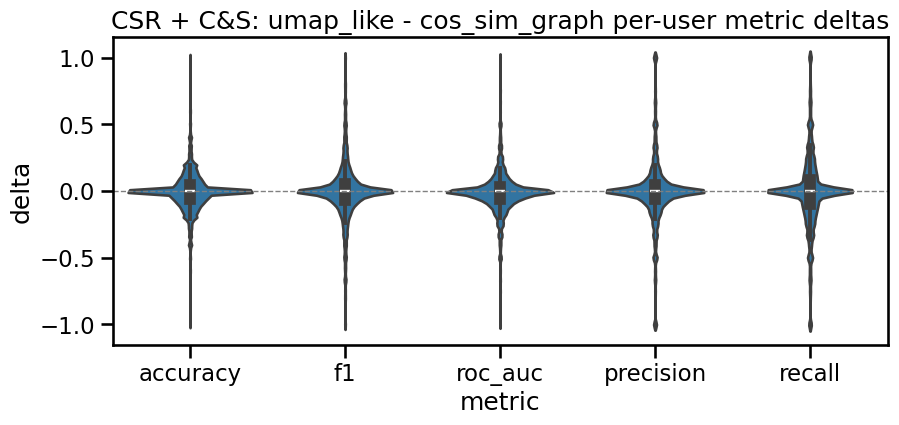


Cross-graph deltas for approach: PRC User-Based (umap_like - cos_sim_graph)


,metric,mean,median,std,count
0,accuracy,-0.000743,0.0,0.061938,154595
1,f1,-0.000129,0.0,0.054858,154595
2,precision,-0.000745,0.0,0.043867,154595
3,recall,-0.002138,0.0,0.098399,154595
4,roc_auc,0.002651,0.0,0.097031,151950


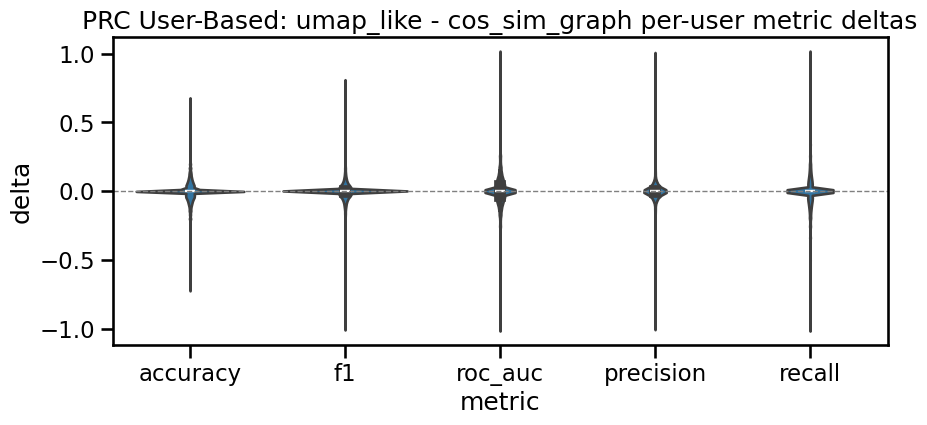


Cross-graph deltas for approach: GNN GCN (umap_like - cos_sim_graph)


,metric,mean,median,std,count
0,accuracy,-0.023587,0.000000,0.131379,345
1,f1,-0.019490,-0.008784,0.179249,335
2,precision,-0.019829,0.000000,0.239754,335
3,recall,-0.058504,0.000000,0.222952,335
4,roc_auc,-0.029273,-0.022046,0.195412,335


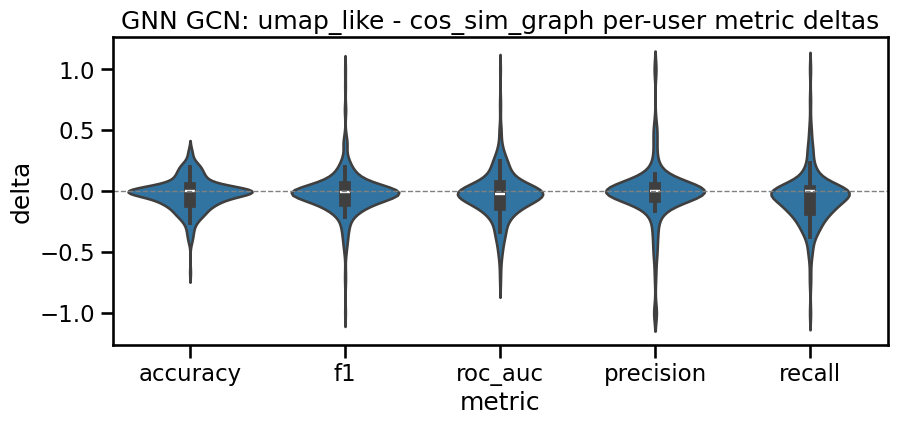


Cross-graph deltas for approach: GNN GraphSAGE (umap_like - cos_sim_graph)


,metric,mean,median,std,count
0,accuracy,0.006774,0.0,0.064251,345
1,f1,0.009586,0.0,0.090188,335
2,precision,0.014616,0.0,0.116202,335
3,recall,0.008715,0.0,0.115729,335
4,roc_auc,0.002797,0.0,0.083092,335


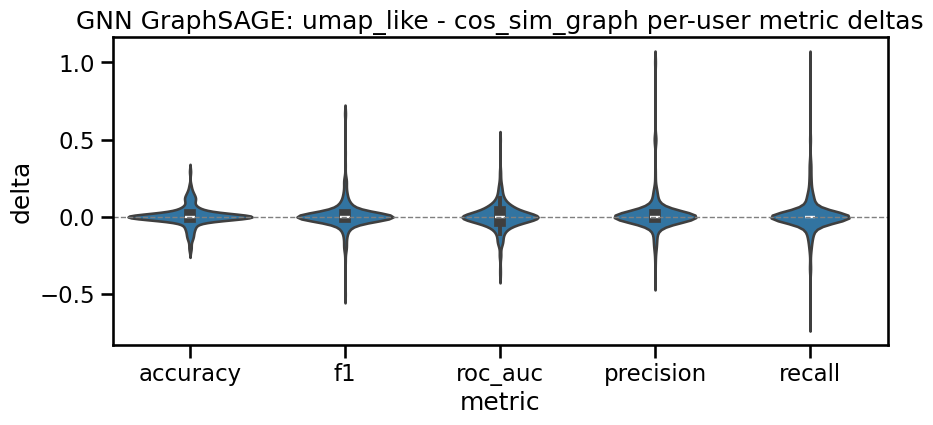

In [7]:
# Cross-graph comparisons: same approach, compare graphs on common users
if not all_results.empty:
    for approach_key, (subdir, fname, label) in APPROACH_PATHS.items():
        sub = all_results[all_results['approach_key'] == approach_key]
        graphs = [g for g in sub['graph'].unique() if g != 'unspecified']
        if len(graphs) < 2:
            continue
        g1, g2 = graphs[:2]
        a = sub[sub['graph'] == g1]
        b = sub[sub['graph'] == g2]
        if 'user_id' not in a.columns or 'user_id' not in b.columns:
            continue
        common = set(a['user_id']) & set(b['user_id'])
        if not common:
            continue
        a = a[a['user_id'].isin(common)].set_index('user_id')
        b = b[b['user_id'].isin(common)].set_index('user_id')
        metric_cols = [m for m in METRICS if m in a.columns and m in b.columns]
        if not metric_cols:
            continue
        diffs = (a[metric_cols] - b[metric_cols]).reset_index()
        diffs = diffs.melt(id_vars='user_id', var_name='metric', value_name='delta')
        print(f"\nCross-graph deltas for approach: {label} ({g1} - {g2})")
        display(diffs.groupby('metric')['delta'].agg(['mean','median','std','count']).reset_index())
        plt.figure(figsize=(10,4))
        sns.violinplot(data=diffs, x='metric', y='delta', inner='box')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.title(f"{label}: {g1} - {g2} per-user metric deltas")
        plt.show()